In [1]:
from aire_scripts.deform_dataloader import CustomDataset, CustomDataset_New
import gc
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

#data = CustomDataset("C:/Users/arpit/Desktop/M005_front/neutral/level_1/input/")
data = CustomDataset_New("C:/Users/arpit/Desktop/M005_front/neutral/level_1/input/", 12)

VALID_SIZE = 0.1
BATCH_SIZE = 1
SEED = 0

np.random.seed(SEED)
device = 'cuda'

len(data)

c:\Users\arpit\.conda\envs\gaussian_splatting\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4726

### Training

In [ ]:
'''

test_vids = ['happy_level_3_014', 'happy_level_2_005', 'happy_level_1_029',
       'happy_level_1_009', 'happy_level_1_028', 'happy_level_3_008',
       'neutral_level_1_024', 'neutral_level_1_026',
       'neutral_level_1_001', 'happy_level_2_002', 'happy_level_3_027',
       'neutral_level_1_023', 'neutral_level_1_016']

train_valid_indices = [idx for idx, v in enumerate(data.videos) if v not in test_vids]
train_valid_vids = [v for v in data.videos if v not in test_vids]
len(train_valid_vids)
'''

4157

In [2]:
# split based on videos - train set videos and test set videos have no overlap

_, _, train_vids, test_vids= train_test_split(
    range(len(set(data.videos))),
    list(set(data.videos)),
    test_size=VALID_SIZE,
    random_state=SEED
)

train_indices = [idx for idx, v in enumerate(data.videos) if v not in test_vids]
valid_indices = [idx for idx, v in enumerate(data.videos) if v in test_vids]


In [ ]:
# stratified split of frames  - stratify by video

'''
train_indices, valid_indices, _, _ = train_test_split(
    range(len(data)),
    data.videos,
    stratify=data.videos,
    test_size=0.9,  #VALID_SIZE,   ## ONLY FOR TESTING
    train_size=0.1,  ## ONLY FOR TESTING
    random_state=SEED
)

len(train_indices), len(valid_indices)
'''

(472, 4254)

In [3]:
# generate subset based on indices
train_split = Subset(data, train_indices) 
valid_split = Subset(data, valid_indices) 

# create batches
train_batches = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
valid_batches = DataLoader(valid_split, batch_size=BATCH_SIZE)

len(valid_batches), len(train_batches)

(508, 4218)

In [4]:
test_vids

['012', '009', '018', '032']

In [5]:
dt = next(iter(valid_batches))

In [6]:
dt[2].shape

torch.Size([1, 12, 1280])

In [17]:
cam_name = ('005_0064',)[0].split("_", maxsplit=3)[0] + "_0001.png"
cam_name

'005_0001.png'

In [9]:
import gc
gc.collect()

238

In [2]:
# load gaussians

from scene import GaussianModel, Scene
from gaussian_renderer import render_motion
from arguments import PipelineParams
from arguments import ModelParams
from argparse import ArgumentParser
import sys
import torch

colmap_path = "C:/Users/arpit/Desktop/M005_front/neutral/level_1/colmap"
sys.argv = f"x --source_path {colmap_path} -r 2".split()

parser = ArgumentParser(description="Training script parameters")
dataset = ModelParams(parser)
args = parser.parse_args(sys.argv[1:])


temp = dataset.extract(args)
gaussians = GaussianModel(sh_degree=3)
scene = Scene(temp, gaussians)

#front_cam = [cam for cam in scene.getTrainCameras() if cam.image_name.startswith('front')]

pipe = PipelineParams(parser)

gaussians.load_ply("C:/Users/arpit/Desktop/sparse_1_final/point_cloud/iteration_30000/point_cloud.ply")

c:\Users\arpit\.conda\envs\gaussian_splatting\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\arpit\Desktop\M005_front\neutral\level_1\colmap
Reading camera 847/847
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  5389


In [11]:
scene.getTrainCameras()[846].colmap_id

1

In [1]:
import gc
gc.collect()

145

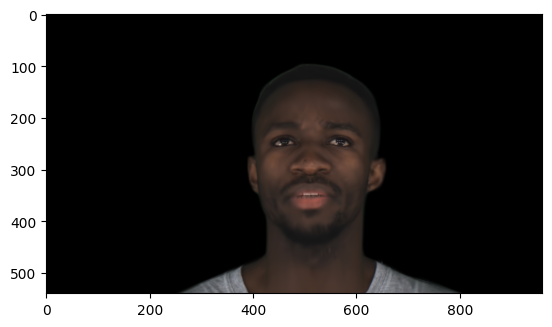

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import torch
from gaussian_renderer import render
from torchvision.io import read_image, ImageReadMode
import matplotlib.pyplot as plt

bg_color = [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
cam = [x for x in scene.getTrainCameras() if x.image_name == "031_0001.png"]

net_image = render(cam[0],
                   gaussians, pipe, background, 
                   scaling_modifier=1.0, 
                   use_trained_exp=temp.train_test_exp)["render"]

plt.imshow(net_image.permute(1, 2, 0).cpu().detach().numpy())

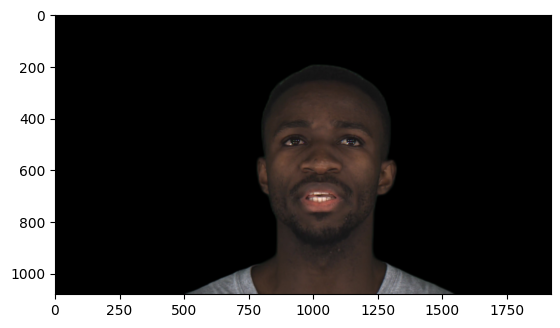

In [5]:
input = read_image("C:/Users/arpit/Desktop/M005_front/neutral/level_1/colmap/images/031_0051.png", mode=ImageReadMode.RGB)
plt.imshow(input.permute(1,2,0))

In [6]:
from utils.loss_utils import l1_loss, l2_loss
from utils.image_utils import psnr
from torchvision import transforms

resize_input = transforms.Resize((input.shape[1]//2, input.shape[2]//2))(input)
resize_input.shape

torch.Size([3, 540, 960])

In [7]:
from torchvision.transforms.functional import convert_image_dtype

l1_loss(convert_image_dtype(resize_input), net_image.cpu())

tensor(0.0038, grad_fn=<MeanBackward0>)

In [8]:
torch.abs((net_image.cpu() - convert_image_dtype(resize_input))).max()

tensor(0.8638, grad_fn=<MaxBackward1>)

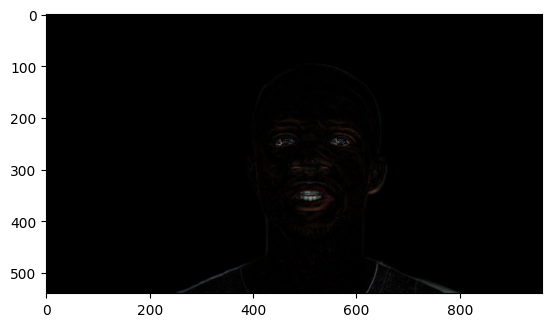

In [9]:
# l1

plt.imshow(torch.abs((net_image.cpu() - convert_image_dtype(resize_input))).permute(1,2,0).detach().numpy())

In [8]:
from lpipsPyTorch.modules.lpips import LPIPS

lpips_obj = LPIPS(net_type='vgg').to('cuda')

In [9]:
lpips_obj(convert_image_dtype(resize_input).to('cuda'), net_image)

tensor([[[[0.0463]]]], device='cuda:0', grad_fn=<SumBackward1>)

In [3]:
import gc
gc.collect()

42

In [10]:
from utils.loss_utils import l1_loss, ssim
from utils.image_utils import psnr
from aire_scripts.deform_net import MLP_New
#from lpipsPyTorch import lpips

model = MLP_New(n_features=11, aud_in=1707, emo_in=1280).to(device)

In [12]:
model.forward(dt[1].to("cuda"), dt[2].to("cuda"))

tensor([[[0.0000, 0.0832, 0.0000, 0.1283, 0.0624, 0.0164, 0.1672, 0.0000,
          0.1051, 0.0000, 0.0000],
         [0.0000, 0.0832, 0.0000, 0.1283, 0.0624, 0.0164, 0.1672, 0.0000,
          0.1051, 0.0000, 0.0000],
         [0.0000, 0.0832, 0.0000, 0.1283, 0.0624, 0.0164, 0.1672, 0.0000,
          0.1051, 0.0000, 0.0000],
         [0.0000, 0.0832, 0.0000, 0.1283, 0.0624, 0.0164, 0.1672, 0.0000,
          0.1051, 0.0000, 0.0000],
         [0.0000, 0.0832, 0.0000, 0.1283, 0.0624, 0.0164, 0.1672, 0.0000,
          0.1051, 0.0000, 0.0000],
         [0.0000, 0.0832, 0.0000, 0.1283, 0.0624, 0.0164, 0.1672, 0.0000,
          0.1051, 0.0000, 0.0000],
         [0.0000, 0.0832, 0.0000, 0.1283, 0.0624, 0.0164, 0.1672, 0.0000,
          0.1051, 0.0000, 0.0000],
         [0.0000, 0.0832, 0.0000, 0.1283, 0.0624, 0.0164, 0.1672, 0.0000,
          0.1051, 0.0000, 0.0000],
         [0.0000, 0.0832, 0.0000, 0.1283, 0.0624, 0.0164, 0.1672, 0.0000,
          0.1051, 0.0000, 0.0000],
         [0.0000, 0

In [10]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
'''

import torch.nn as nn

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=0.1)
        nn.init.zeros_(m.bias)

model.apply(init_weights)
'''

'\n\nimport torch.nn as nn\n\ndef init_weights(m):\n    if isinstance(m, nn.Linear):\n        nn.init.xavier_uniform_(m.weight, gain=0.1)\n        nn.init.zeros_(m.bias)\n\nmodel.apply(init_weights)\n'

In [2]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))


model size: 5.896MB


In [12]:
gaussians._features_dc.requires_grad = False
gaussians._features_rest.requires_grad = False
gaussians._xyz.requires_grad = False
gaussians._rotation.requires_grad = False
gaussians._scaling.requires_grad = False
gaussians._opacity.requires_grad = False

In [13]:
from torch.optim.lr_scheduler import ExponentialLR

scheduler = ExponentialLR(opt, gamma=0.95)

In [14]:
bg_color = [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)
simulated_batch_size = 2

In [ ]:
from lpipsPyTorch.modules.lpips import LPIPS

lpips_obj = LPIPS(net_type='vgg').to(device)
lmd_path = "C:/Users/arpit/Desktop/M005_front/neutral/level_1/lip_lmds"

In [12]:
from torchvision.transforms.functional import crop, convert_image_dtype

In [15]:
%%time

for epoch in range(1):
    losses = []
    #train_lpips = []
    model.train()
    loss_opt = torch.Tensor([0]).to(device)
    for batch_num, input_data in enumerate(train_batches):
        
        gt_image, aud, emo, name = input_data
        gt_image = gt_image[0].to(device)
        aud = aud.to(device)
        emo = emo.to(device)
        
        output = model(aud, emo)

        cam_name = name[0].split("_", maxsplit=3)[-1] + ".png"
        cam = [x for x in scene.getTrainCameras() if x.image_name == cam_name]

        output_image = render_motion(cam[0],
                   gaussians, pipe, background,
                   deform_output=output.reshape(5389, -1),
                   scaling_modifier=1.0, 
                   use_trained_exp=temp.train_test_exp, 
                   )["render"]
        
        Ll1 = l1_loss(output_image, gt_image)
        ssim_value = ssim(output_image, gt_image)

        '''
        lpips_value = lpips_obj(output_image, gt_image)#.item()

        # lip loss
        lip_lmd = np.load(f"{lmd_path}/{name[0]}.npy")
        xs = [x for x in lip_lmd[48:,0]]
        ys = [y for y in lip_lmd[48:,1]]
        
        crop_gt = crop(
            img=convert_image_dtype(gt_image, dtype=torch.uint8),
            top=int(min(ys)), left=int(min(xs)),
            height=int(max(ys)-min(ys)),
            width=int(max(xs)-min(xs))
        )
        crop_gt = convert_image_dtype(crop_gt)

        crop_output = crop(
            img=convert_image_dtype(output_image, dtype=torch.uint8),
            top=int(min(ys)), left=int(min(xs)),
            height=int(max(ys)-min(ys)),
            width=int(max(xs)-min(xs))
        )
        crop_output = convert_image_dtype(crop_output)
        
        lip_loss = lpips_obj(crop_output, crop_gt)
        '''

        loss = 0.8 * Ll1 + 0.2 * (1.0 - ssim_value) #+ 0.1 * lpips_value + 0.05 * lip_loss
        loss_opt = loss_opt + loss 
        losses.append(loss.item())
        #opt.step()

        if (batch_num > 0) and (batch_num % simulated_batch_size) == 0:
            loss_opt.backward()
            opt.step()
            print('\tEpoch %d | Batch %d | Loss %6.3f' % (epoch, batch_num, torch.sum(loss_opt)/simulated_batch_size))
            opt.zero_grad()
            loss_opt = torch.Tensor([0]).to(device)
            torch.cuda.empty_cache()
            
    if loss_opt.item() != 0:
        loss_opt.backward()
        opt.step()
        opt.zero_grad()

    scheduler.step()    
    
    v_losses = []
    v_psnrs = []
    #v_lpips = []
    model.eval()
    with torch.no_grad():
        for batch_num, input_data in enumerate(valid_batches):
            gt_image, aud, emo, _ = input_data
            gt_image = gt_image[0].to(device)
            aud = aud.to(device)
            emo = emo.to(device)

            output = model(aud, emo)

            cam_name = name[0].split("_", maxsplit=3)[-1] + ".png"
            cam = [x for x in scene.getTrainCameras() if x.image_name == cam_name]
            
            output_image = render_motion(cam[0],
                   gaussians, pipe, background,
                   deform_output=output.reshape(5389, -1),
                   scaling_modifier=1.0, 
                   use_trained_exp=temp.train_test_exp, 
            )["render"]
            
            Ll1 = l1_loss(output_image, gt_image)
            ssim_value = ssim(output_image, gt_image)

            '''
            lpips_value = lpips_obj(output_image, gt_image)#.item()

            # lip loss
            lip_lmd = np.load(f"{lmd_path}/{name[0]}.npy")
            xs = [x for x in lip_lmd[48:,0]]
            ys = [y for y in lip_lmd[48:,1]]
            
            crop_gt = crop(
                img=convert_image_dtype(gt_image, dtype=torch.uint8),
                top=int(min(ys)), left=int(min(xs)),
                height=int(max(ys)-min(ys)),
                width=int(max(xs)-min(xs))
            )
            crop_gt = convert_image_dtype(crop_gt)
            
            crop_output = crop(
                img=convert_image_dtype(output_image, dtype=torch.uint8),
                top=int(min(ys)), left=int(min(xs)),
                height=int(max(ys)-min(ys)),
                width=int(max(xs)-min(xs))
            )
            crop_output = convert_image_dtype(crop_output)
            lip_loss = lpips_obj(crop_output, crop_gt)
            '''

            loss = 0.8 * Ll1 + 0.2 * (1.0 - ssim_value) #+ 0.1 * lpips_value + 0.05 * lip_loss
            v_losses.append(loss.item())
            v_psnr = psnr(output_image, gt_image).mean().double()
            v_psnrs.append(v_psnr.item())
            #v_lpips.append(lpips_value)
        
    print(
        'Epoch %d | Train Loss %6.3f | Val Loss %6.3f | Val PSNR %6.3f' % 
        (epoch, sum(losses)/len(losses), sum(v_losses)/len(v_losses), sum(v_psnrs)/len(v_psnrs))
    )

	Epoch 0 | Batch 2 | Loss  0.010
	Epoch 0 | Batch 4 | Loss  0.006
	Epoch 0 | Batch 6 | Loss  0.005
Epoch 0 | Train Loss  0.006 | Val Loss  0.017 | Val PSNR 30.924
Wall time: 20.5 s


In [16]:
psnr(output_image, gt_image)

tensor([[30.1550],
        [31.0011],
        [31.1927]], device='cuda:0')

In [15]:
lpips_obj(crop_output, crop_gt)

tensor([[[[0.3702]]]], device='cuda:0')

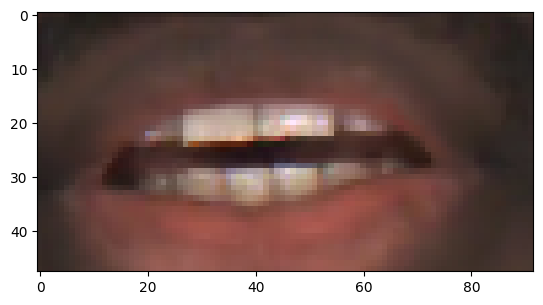

In [23]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import matplotlib.pyplot as plt

plt.imshow(crop_gt.permute(1,2,0).cpu())

In [25]:
import gc
gc.collect()

21

In [18]:
torch.min(output_image), torch.max(output_image)

(tensor(0., device='cuda:0'), tensor(0.7716, device='cuda:0'))

In [19]:
torch.min(gt_image), torch.max(gt_image)

(tensor(0., device='cuda:0'), tensor(0.9961, device='cuda:0'))

In [20]:
ssim(output_image, gt_image)

tensor(0.9494, device='cuda:0')

In [ ]:
lpips(output_image, gt_image).item()

c:\Users\arpit\.conda\envs\gaussian_splatting\lib\site-packages\torchvision\models\_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
c:\Users\arpit\.conda\envs\gaussian_splatting\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0.06891312450170517

(array([1.27426e+06, 1.39930e+05, 9.15910e+04, 2.86070e+04, 1.24630e+04,
        5.96700e+03, 1.91800e+03, 3.89000e+02, 3.50000e+01, 4.00000e+01]),
 array([0.        , 0.09960784, 0.19921568, 0.29882354, 0.39843136,
        0.49803922, 0.5976471 , 0.6972549 , 0.7968627 , 0.8964706 ,
        0.99607843], dtype=float32),
 <BarContainer object of 10 artists>)

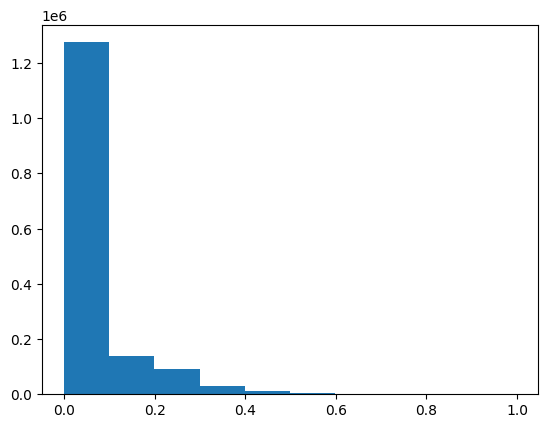

In [ ]:
import matplotlib.pyplot as plt

plt.hist(gt_image.flatten().cpu().detach().numpy())

(array([1.245639e+06, 1.157540e+05, 1.195090e+05, 4.393300e+04,
        1.464900e+04, 1.010000e+04, 4.680000e+03, 8.660000e+02,
        6.600000e+01, 4.000000e+00]),
 array([0.        , 0.08751742, 0.17503484, 0.26255226, 0.35006967,
        0.43758708, 0.5251045 , 0.6126219 , 0.70013934, 0.7876567 ,
        0.87517416], dtype=float32),
 <BarContainer object of 10 artists>)

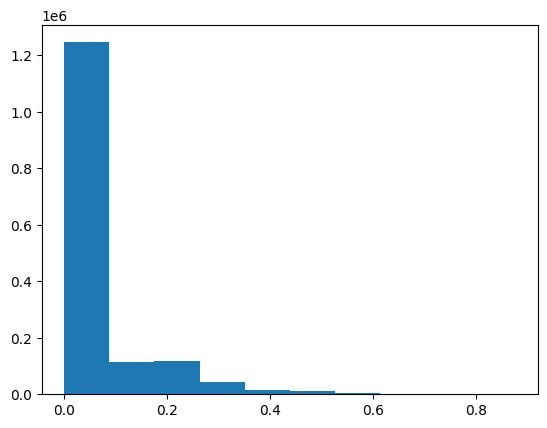

In [ ]:
plt.hist(output_image.flatten().cpu().detach().numpy())

In [ ]:
gt_image.shape

torch.Size([3, 540, 960])

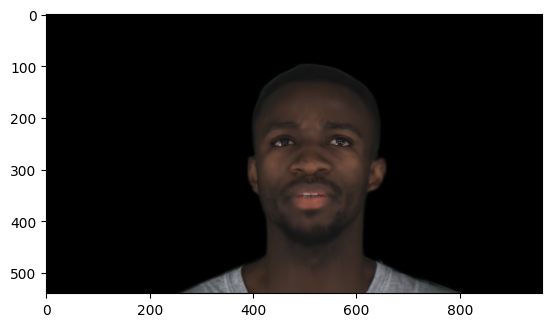

In [21]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # else imshow will crash kernel

import matplotlib.pyplot as plt


plt.imshow(output_image.permute(1, 2, 0).cpu().detach().numpy())

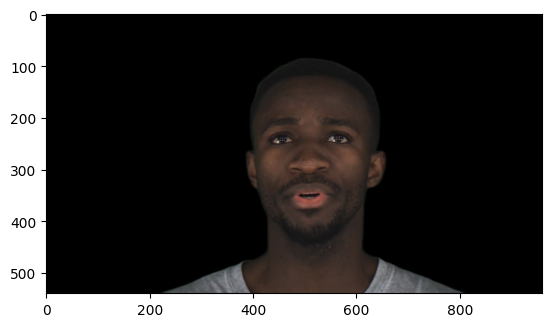

In [22]:
plt.imshow(gt_image.permute(1, 2, 0).cpu().detach().numpy())

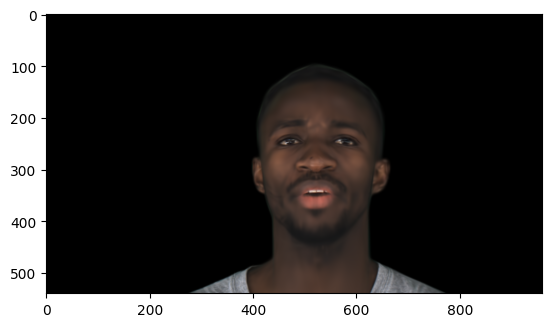

In [ ]:
canon_image = render(front_cam[0],
                   gaussians, pipe, background, 
                   scaling_modifier=1.0, 
                   use_trained_exp=temp.train_test_exp)["render"]

plt.imshow(canon_image.permute(1, 2, 0).cpu().detach().numpy())

In [ ]:
l1_loss(gt_image, output_image)

tensor(0.0113, device='cuda:0')

In [23]:
gc.collect()

21

### Inference

In [3]:
test_vids = ['neutral_level_1_031']
'''
              'happy_level_2_005', 'happy_level_1_029',
       'happy_level_1_009', 'happy_level_1_028', 'happy_level_3_008',
       'neutral_level_1_024', 'neutral_level_1_026',
       'neutral_level_1_001', 'happy_level_2_002', 'happy_level_3_027',
       'neutral_level_1_023', 'neutral_level_1_016']
'''

test_indices = [v for v in data.videos if v in test_vids[0]]
test_indices = [i for i, x in enumerate(data.videos) if x == test_vids[0]]
len(test_indices)

95

In [4]:
import gc
gc.collect()

21

In [5]:
test_split = Subset(data, test_indices)  
test_batches = DataLoader(test_split, batch_size=BATCH_SIZE)

len(test_batches)

95

In [ ]:
# load gaussians


from scene import GaussianModel, Scene
from gaussian_renderer import render
from arguments import PipelineParams, OptimizationParams
from arguments import ModelParams
from argparse import ArgumentParser
import sys
import torch

colmap_path = "C:/Users/arpit/Desktop/M005_front/neutral/level_1/colmap"
sys.argv = f"x --source_path {colmap_path} -r 2".split()

parser = ArgumentParser(description="Training script parameters")
dataset = ModelParams(parser)
args = parser.parse_args(sys.argv[1:])


temp = dataset.extract(args)
gaussians = GaussianModel(sh_degree=3)
scene = Scene(temp, gaussians)

pipe = PipelineParams(parser)

gaussians.load_ply("C:/Users/arpit/Desktop/sparse_1_final/point_cloud/iteration_30000/point_cloud.ply")

C:\Users\arpit\Desktop\M005_front\neutral\level_1\colmap
Reading camera 847/847
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  5389


In [ ]:
from aire_scripts.deform_net import MLP
from utils.loss_utils import ssim
from utils.image_utils import psnr
import torch

model = MLP(n_gaussians=5389, n_features=11, aud_in=1707, emo_in=1280).to('cuda')
checkpoint = torch.load("C:/Users/arpit/Desktop/deform_model.pth")#, weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

In [ ]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 1474.738MB


In [9]:
bg_color = [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)

from lpipsPyTorch.modules.lpips import LPIPS

lpips_obj = LPIPS(net_type='vgg').to(device)

In [ ]:
t_ssims = []
t_psnrs = []
t_images = []
t_l1s = []
t_lpips = []

from utils.loss_utils import l1_loss
from gaussian_renderer import render_motion
from tqdm import tqdm

with torch.no_grad():
        for batch_num, input_data in enumerate(tqdm(test_batches)):
            gt_image, aud, emo, name = input_data
            gt_image = gt_image[0].to(device)
            aud = aud.to(device)
            emo = emo.to(device)            
            output = model(aud, emo)

            cam_name = name[0].split("_", maxsplit=3)[-1] + ".png"
            cam = [x for x in scene.getTrainCameras() if x.image_name == cam_name]
            
            output_image = render_motion(cam[0],
                   gaussians, pipe, background,
                   deform_output=output.reshape(5389, -1), 
                   scaling_modifier=1.0, 
                   use_trained_exp=temp.train_test_exp)["render"]
            
            t_images.append(output_image)
            ssim_value = ssim(output_image, gt_image)
            t_ssims.append(ssim_value.item())
            t_psnr = psnr(output_image, gt_image).mean().double()
            t_psnrs.append(t_psnr.item())
            t_l1s.append(l1_loss(output_image, gt_image).item())
            t_lpips.append(lpips_obj(output_image, gt_image).item())

  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [01:31<00:00,  2.70s/it]


In [11]:
sum(t_l1s)/len(t_l1s)

0.003297740778447512

In [12]:
sum(t_lpips)/len(t_lpips)

0.06710700603092418

In [13]:
sum(t_ssims)/len(t_ssims)

0.9760331581620609

In [14]:
sum(t_psnrs)/len(t_psnrs)

37.14334476695341

In [15]:
import gc
gc.collect()

209

In [16]:
t_images = [x.permute(1, 2, 0).cpu().detach().numpy() for x in t_images]

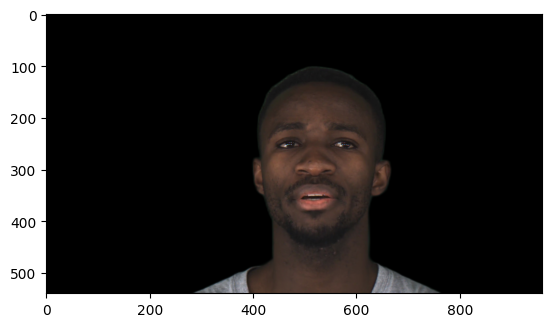

In [17]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # else imshow will crash kernel

import matplotlib.pyplot as plt


plt.imshow(gt_image.permute(1, 2, 0).cpu().detach().numpy())

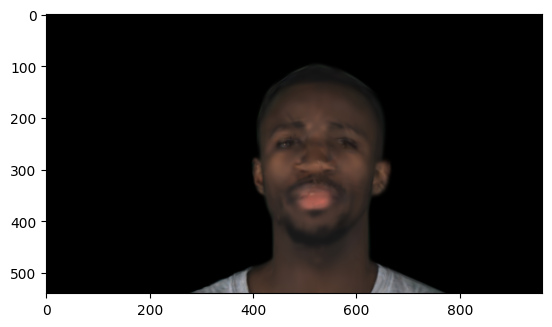

In [18]:
plt.imshow(output_image.permute(1, 2, 0).cpu().detach().numpy())

In [19]:
t_images[0].shape

(540, 960, 3)

In [20]:
from PIL import Image

i = 1

for im in t_images:
    tmp = Image.fromarray((im*255).astype(np.uint8))
    tmp.save(f"C:/Users/arpit/Desktop/neutral_003/{str(i)}.png")
    i += 1

In [21]:
import gc
gc.collect()

63

In [23]:
gt_image.dtype

torch.float32